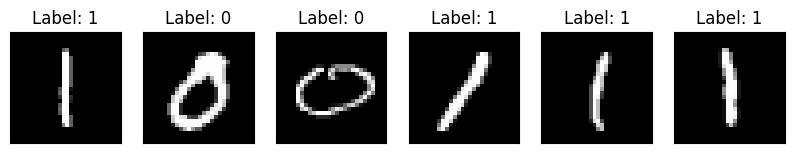

Training [5%]	Loss: 0.4604
Training [10%]	Loss: 0.3611
Training [15%]	Loss: 0.3549
Training [20%]	Loss: 0.3483
Training [25%]	Loss: 0.3430
Training [30%]	Loss: 0.3429
Training [35%]	Loss: 0.3428
Training [40%]	Loss: 0.3403
Training [45%]	Loss: 0.3327
Training [50%]	Loss: 0.3265
Training [55%]	Loss: 0.3263
Training [60%]	Loss: 0.3266
Training [65%]	Loss: 0.3259
Training [70%]	Loss: 0.3223
Training [75%]	Loss: 0.3201
Training [80%]	Loss: 0.3205
Training [85%]	Loss: 0.3195
Training [90%]	Loss: 0.3204
Training [95%]	Loss: 0.3205
Training [100%]	Loss: 0.3175


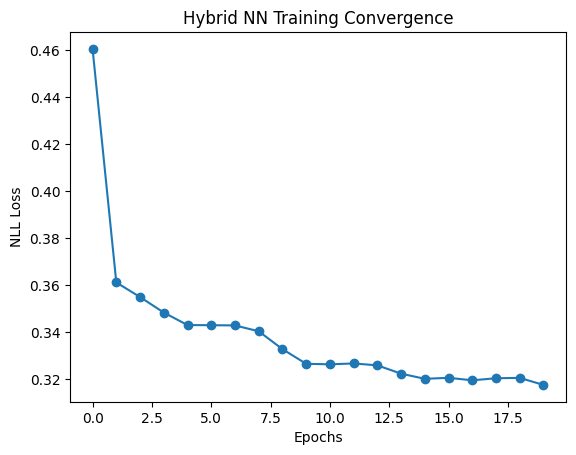

Performance on test data:
	Loss: 0.3253
	Accuracy: 100.0%


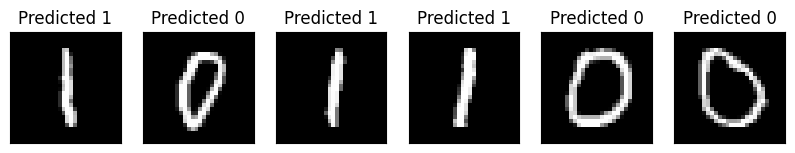

In [3]:
# Upgrade and install the latest Qiskit and Aer packages
!pip install --upgrade qiskit qiskit-aer

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
from torchvision import datasets, transforms

# Qiskit imports
import qiskit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer  # import Aer from qiskit_aer

# Import Qiskit Circuit and Parameter objects
from qiskit.circuit import QuantumCircuit as QiskitCircuit, Parameter

###########################################
# Quantum Circuit Wrapper Class
###########################################
class QuantumCircuit:
    """
    This class provides a simple interface for interacting with a parameterized quantum circuit.
    """
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

        # Create a parameter for the rotation angle.
        self.theta = Parameter('theta')
        # Create a quantum circuit with n_qubits and n classical bits for measurement.
        self.circuit = QiskitCircuit(n_qubits, n_qubits)
        all_qubits = list(range(n_qubits))

        # Apply Hadamard to all qubits.
        for qubit in all_qubits:
            self.circuit.h(qubit)
        self.circuit.barrier()

        # Apply a parameterized Ry gate to each qubit.
        for qubit in all_qubits:
            self.circuit.ry(self.theta, qubit)
        self.circuit.barrier()

        # Measure all qubits.
        self.circuit.measure(all_qubits, all_qubits)

    def run(self, thetas):
        """
        Run the quantum circuit for a list of theta values and compute an expectation value.
        For simplicity, this function assumes a one-qubit circuit.
        """
        # Transpile the circuit for the backend.
        transpiled_qc = transpile(self.circuit, self.backend)
        # Use the new Qiskit API: assign_parameters instead of bind_parameters.
        bound_circuits = [transpiled_qc.assign_parameters({self.theta: theta}) for theta in thetas]
        # Run the list of bound circuits.
        job = self.backend.run(bound_circuits, shots=self.shots)

        # Retrieve the counts for the first circuit in the list.
        result = job.result().get_counts(0)
        if not result:
            return np.array([0.0])

        # For a one-qubit circuit the measurement outcomes are strings "0" or "1".
        counts = np.array(list(result.values()))
        states = list(result.keys())
        # Convert bit string to integer (works for one qubit only).
        states_int = np.array([int(state, 2) for state in states])
        probabilities = counts / self.shots
        # Compute the expectation value.
        expectation = np.sum(states_int * probabilities)
        return np.array([expectation])

##############################################################
# HybridFunction: Enabling Quantum-Classical Differentiation
##############################################################
class HybridFunction(Function):
    """Hybrid quantum-classical function for PyTorch autograd."""
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        # Assume that 'input' is a one-element tensor representing theta.
        theta = input.item()
        expectation_z = ctx.quantum_circuit.run([theta])[0]
        # Wrap the expectation value as a float tensor.
        result = torch.tensor([expectation_z], dtype=torch.float32)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        (input, expectation_z) = ctx.saved_tensors
        input_value = input.item()
        shift = ctx.shift
        # Use the parameter-shift rule for gradient estimation.
        exp_right = ctx.quantum_circuit.run([input_value + shift])[0]
        exp_left  = ctx.quantum_circuit.run([input_value - shift])[0]
        gradient = (exp_right - exp_left) / (2 * shift)
        grad_input = torch.tensor([gradient], dtype=torch.float32) * grad_output
        return grad_input, None, None

######################################
# Hybrid Module Wrapping the Quantum Layer
######################################
class Hybrid(nn.Module):
    """Hybrid layer that wraps the quantum circuit as a differentiable layer."""
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

######################################
# Data Preparation: MNIST (Digits 0 and 1)
######################################
# Transformation: convert images to tensors.
transform = transforms.Compose([transforms.ToTensor()])

# Prepare training set: only use digits 0 and 1.
n_samples_train = 100
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
idx0 = np.where(train_dataset.targets == 0)[0][:n_samples_train]
idx1 = np.where(train_dataset.targets == 1)[0][:n_samples_train]
idx_train = np.concatenate((idx0, idx1))
train_dataset.data = train_dataset.data[idx_train]
train_dataset.targets = train_dataset.targets[idx_train]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Prepare test set: only use digits 0 and 1.
n_samples_test = 50
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
idx0_test = np.where(test_dataset.targets == 0)[0][:n_samples_test]
idx1_test = np.where(test_dataset.targets == 1)[0][:n_samples_test]
idx_test = np.concatenate((idx0_test, idx1_test))
test_dataset.data = test_dataset.data[idx_test]
test_dataset.targets = test_dataset.targets[idx_test]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Visualize a few training examples.
n_samples_show = 6
fig, axes = plt.subplots(1, n_samples_show, figsize=(10, 3))
data_iter = iter(train_loader)
for i in range(n_samples_show):
    images, targets = next(data_iter)
    axes[i].imshow(images[0].squeeze(), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(targets.item()))
plt.show()

#########################################################
# CNN with Integrated Hybrid Quantum Layer
#########################################################
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        # Fully connected layers.
        # After two conv+pooling stages for 28x28 images, the feature map size becomes 16x4x4=256.
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        # Hybrid quantum layer using Aer simulator.
        backend = Aer.get_backend('aer_simulator')
        self.hybrid = Hybrid(backend, shots=100, shift=np.pi/2)

    def forward(self, x):
        # Convolutional operations.
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten.
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output shape: [batch, 1]
        # Process through the hybrid quantum layer.
        outputs = []
        for i in range(x.size(0)):
            hybrid_out = self.hybrid(x[i])
            outputs.append(hybrid_out)
        x = torch.stack(outputs)
        # Convert the single quantum expectation into two outputs (as if probabilities for classes 0 and 1).
        x = torch.cat((x, 1 - x), dim=-1)
        # Apply log softmax to produce log probabilities (compatible with NLLLoss).
        return F.log_softmax(x, dim=1)

######################################
# Model Training and Evaluation
######################################
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()
epochs = 20
loss_list = []

# Training loop.
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass: model output shape is [batch, 2]; target is 0 or 1.
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    avg_loss = sum(total_loss) / len(total_loss)
    loss_list.append(avg_loss)
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, avg_loss))

plt.figure()
plt.plot(loss_list, marker='o')
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('NLL Loss')
plt.show()

# Evaluation on test set.
model.eval()
test_loss = []
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss.append(loss_func(output, target).item())
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss = sum(test_loss) / len(test_loss)
accuracy = 100. * correct / len(test_loader)
print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(test_loss, accuracy))

# Visualize predictions on test data.
n_samples_show = 6
fig, axes = plt.subplots(1, n_samples_show, figsize=(10, 3))
with torch.no_grad():
    count = 0
    for data, target in test_loader:
        if count == n_samples_show:
            break
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].squeeze(), cmap='gray')
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        count += 1
plt.show()